## What arXiv is

The arXiv (pronounced *archive*) is a repository of electronic preprints, known as e-prints, of scientific papers in the field of **mathematics**, **physics**, **astronomy**, **computer science**, **quantitative biology**, **statistics**, and **quantitative finance**, which can be accessed online

## What we will do with it

### Part 1

In this project, we will extract prepints of the API of arXiv, collect the abstract of each article, clean the text (tokenize, lowercase, extract stopwords, lemmatize) and then extract the most important words with **TF-IDF**, and remove the rest. Then we will start building a network graph(directed), using the papers and the words of each paper as nodes. In order for the nodes to be distinguised between each other(nodes and words), we will assume that **article-nodes** will always have *non-zero out-degrees* and **word-nodes** the opposite.

### Part 2

This graph will then be the basis for a new undirected graph, where all word-nodes will turn into edges. Since we can't have multiple edges between the two same nodes, we will instead set the weight of the edge. The more common words, the higher the **weight**.



### Part 3

Furthermore we will also do **community detection** on the undirected graph, useful for finding papers in different, and potentially unexpected fields of study.

***

## Extract data

The script below is used to extract data from ArXiv API. [This](https://github.com/davidar/oai-sync) is the link that the script has been sourced from.

In [ ]:
# sync any new changes since the date of the last sync
./oai-sync.pl --baseURL=http://export.arxiv.org/oai2 --metadataPrefix=arXiv \
              --dumpDir=./arxiv0/ --from='2016-01-01'

## A look at the dataset

Let's first load all dependencies used later

In [112]:
import re
import nltk
import datetime
import time
import numpy as np
import os
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from prettyprint import pp
from string import punctuation
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import operator
import community
#import louvain
import collections
from collections import Counter
import pprint
import math
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread
import random
%matplotlib inline

Load a sample of the dataset in order to have a clear picture of what our main dataset will be like 

In [6]:
# Create a function that takes a subdirectory as an input
# and outputs a list of filepaths of xml files
def get_all_harvested_paths(subdir):
    filepaths = list()
    for file in os.listdir(subdir):
        if file.endswith(".xml"):
            filepaths.append(subdir + "/" + file)
    return filepaths

In [42]:
# Create a function that process all files into a pandasdataframe
# in order to do some statistics on the data
files = get_all_harvested_paths("data/data_full")
df = pd.DataFrame()

# For each file create a temporal dataframe and add it to the main one
for fp in files:
    
    # Load the xml into a soup and late create a dataframe with records as rows
    soup = BeautifulSoup(open(fp), "lxml")
    
    temp_data = pd.DataFrame.from_records([(record.header.identifier.contents[0].encode('utf-8'), 
                                            record.metadata.title.contents[0].encode('utf-8'), 
                                            record.metadata.abstract.contents[0].encode('utf-8'),
                                            record.header.datestamp.contents[0].encode('utf-8'),
                                            record.header.setspec.contents[0].encode('utf-8'))
                    for record in soup.find_all('record')],
                      columns=('identifier','title','abstract','date','topic'))
    
    df = pd.concat([df,temp_data], ignore_index=True)

# Change type from string to datatime
df['date'] =pd.to_datetime(df.date)

In [43]:
# Print sample
df.head()

,identifier,title,abstract,date,topic
0,oai:arXiv.org:1505.04344,On the maximum quartet distance between phylog...,A conjecture of Bandelt and Dress states tha...,2016-02-04,cs
1,oai:arXiv.org:1505.04346,Limits to the precision of gradient sensing wi...,Gradient sensing requires at least two measu...,2016-04-27,physics:physics
2,oai:arXiv.org:1505.04350,Differentiation and integration operators on w...,We show that some previous results concernin...,2016-04-04,math
3,oai:arXiv.org:1505.04352,A Coding Theorem for Bipartite Unitaries in Di...,We analyze implementations of bipartite unit...,2016-06-09,physics:quant-ph
4,oai:arXiv.org:1505.04355,Resonant Trapping in the Galactic Disc and Hal...,With the use of a detailed Milky Way nonaxis...,2016-10-31,physics:astro-ph


In [9]:
# Print basic statistics of the sorted-by-date dataset
df.sort_values(by='date').describe()

,identifier,title,abstract,date
count,37000,37000,37000,37000
unique,37000,36992,36997,255
top,oai:arXiv.org:1505.07748,Recent results from NA61/SHINE,For a pair of quantum channels with the same...,2016-03-23 00:00:00
freq,1,2,2,1231
first,NaN,NaN,NaN,2016-01-01 00:00:00
last,NaN,NaN,NaN,2016-11-30 00:00:00


In [10]:
# Print types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37000 entries, 0 to 36999
Data columns (total 4 columns):
identifier    37000 non-null object
title         37000 non-null object
abstract      37000 non-null object
date          37000 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 1.1+ MB


In [11]:
# Print some statistics
max_date = df.sort_values(by='date').date.max()
min_date = df.sort_values(by='date').date.min()

print "Data before processing\n----------------------"
print "Dates : %s - %s" % (min_date,max_date)
print "Number of papers : %d" % len(df)
print "Number of files: %d" % len(files)
print "Total size on disk: 79.9MB"

Data before processing
----------------------
Dates : 2016-01-01 00:00:00 - 2016-11-30 00:00:00
Number of papers : 37000
Number of files: 100
Total size on disk: 79.9MB


## Build fundamental functions

Now, we will create the functions that will read the API from the ArXiv website, clean the data, calculate the TF-IDF and then pass the data into an undirected graph

In [12]:
# Create a function that takes a raw text as input
# and outputs a list of tokens
def tokenizer(text):
    # Remove punctuation and not usual characters
    text = ''.join(letter for letter in text if letter not in punctuation)
    text = re.sub(r'[^\w-]+',' ',text)
    
    # Remove numbers
    text = re.sub(r'\d+','',text)
    
    # Remove stopwords and lower every word
    tokens = nltk.word_tokenize(text)
    return tokens

In [13]:
# Create a dunction that takes a list of tokens as input
# and outputs a list of clean(without stopwords), lower case tokens
def remove_stopwords(tokens):
    '''
    Remove stopwords and lower-case everyword
    '''
    stopwords = nltk.corpus.stopwords.words('english')
    new_tokens = [word.lower() for word in tokens if word.lower() not in stopwords]
    return new_tokens

In [14]:
# Create a function that takes a list of tokens as input
# and outputs a list of lemmatized tokens
def token_lemmatizer(tokens):
    '''
    lemmatize list of tokens
    '''
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = list()
    for t in tokens:
        lemmatized = wordnet_lemmatizer.lemmatize(t)
        if(len(lemmatized) > 1):
            lemmatized_tokens.append(lemmatized)
    return lemmatized_tokens

In [20]:
# Create a function that takes a filepath as an input
# and uses a tempory dictionary in order to feed 3 global variables
def process_harvested_file(filepath):
    
    # Set global variables
    global processed_papers
    global corpus_words_freq
    global abs_counter
    
    # Start timer
    _start_time = time.time()
    
    # Load file into a soup
    soup = BeautifulSoup(open(filepath), "lxml")
    records = soup.find_all('record')

    # Create the temporary dictionary with the variables needed
    for r in records:
        tmp_paper = dict()
        tmp_paper['identifier'] = r.header.identifier.contents[0].encode('utf-8')
        tmp_paper['title'] = r.metadata.title.contents[0].encode('utf-8')
        tmp_paper['abstract'] = r.metadata.abstract.contents[0].encode('utf-8')
        
        # Create new keys with empty dicts as values in the temporary dictionary
        tmp_paper['tf'] = list()
        tmp_paper['idf'] = dict()
        tmp_paper['tfidf'] = dict()

        # Use the tokenizer() function to tokenize the abstract
        tokenized = tokenizer(tmp_paper['abstract'])
        
        # Use the remove_stopwords() function to clean and lowercase tokens
        valuable_tokens = remove_stopwords(tokenized)
        
        # Use the token_lemmatizer() function to lemmatize tokens
        lemmatized_tokens = token_lemmatizer(valuable_tokens)
        
        # Create a new key in the temporary dictionary with the proccessed tokens
        tmp_paper['words'] = lemmatized_tokens

        # Feed counter with unique number of tokens
        for token in tmp_paper['words']:
            if token not in corpus_words_freq:
                corpus_words_freq[token] = 1
            else:
                corpus_words_freq[token] += 1

        
        # Feed the tf key with the frequency distance of the proccesed tokens
        tmp_paper['tf'] = nltk.FreqDist(tmp_paper['words'])
        processed_papers[tmp_paper['identifier']] = tmp_paper

        # Use this function to track processing state of abstracts
        abs_counter += 1
        if abs_counter % 1000 == 0:
            print abs_counter,'papers have been input into the engine'

    # Stop timer        
    _stop_time = time.time()
    print("Finished harvesting file %s in: %s" % (filepath.split("/")[-1], str(datetime.timedelta(seconds=_stop_time-_start_time))))

In [16]:
# Create a function that calculates the idf
def calculate_idf():
    
    # Set global variables
    global processed_papers
    global corpus_words_freq
    
    # Start timer
    _start_time = time.time()
    
    idf_counter = 0
    total_texts = len(processed_papers)
    for paper in processed_papers.keys():
        for word in processed_papers[paper]['tf'].keys():
            processed_papers[paper]['idf'][word] = np.log(total_texts/corpus_words_freq[word])
        idf_counter += 1
        
        # Use this function to track processing state of IDFs
        if idf_counter % 5000 == 0:
            print idf_counter,'IDF\'s calculated.'
    
    # Stop timer
    _stop_time = time.time()
    print("Finished IDF in: %s" % str(datetime.timedelta(seconds=_stop_time-_start_time)))

Now that all words in the entire corpus has been counted we can calculate the tf-idf for each word, in each abstract

In [17]:
# Create function that calculates the TF-IDF
def calculate_tfidf():
    
    # Set global variables
    global processed_papers

    # Start timer
    _start_time = time.time()
    tfidf_counter = 0
    for paper in processed_papers.keys():
        for word in processed_papers[paper]['tf'].keys():
            tfidf = processed_papers[paper]['tf'][word]*processed_papers[paper]['idf'][word]
            processed_papers[paper]['tfidf'][word] = tfidf

        # Sort (descending) the list by dict value (tfidf)
        processed_papers[paper]['tfidf_sorted'] = sorted(processed_papers[paper]['tfidf'].items(), key=lambda x: x[1], reverse=True)
        
        # Cut the list in half, leaving the most significant words.
        processed_papers[paper]['tfidf_sorted'] = processed_papers[paper]['tfidf_sorted'][:len(processed_papers[paper]['tfidf_sorted'])/2]

        # Delete unused keys from dictionary to save some space in memory
        del processed_papers[paper]['words'] # Remove unused words
        del processed_papers[paper]['abstract'] # Remove abstract
        del processed_papers[paper]['tf']  # Remove unused TF
        del processed_papers[paper]['idf'] # Remove unused IDF
        del processed_papers[paper]['tfidf'] # Remove unsorted TF-IDF values
        
        # Use this function to track processing state of TF-IDFs
        tfidf_counter += 1
        if tfidf_counter % 10000 == 0:
            print tfidf_counter,'TF-IDF\'s calculated.'
    
    # Stop timer
    _stop_time = time.time()
    print("Finished TF-IDF in: %s" % str(datetime.timedelta(seconds=_stop_time-_start_time)))

## Globals for all papers

In [18]:
# Create dictionary used for storing each word in the whole campus as key, and frequency as value.
processed_papers = dict()
corpus_words_freq = dict()
abs_counter = 0

## Execution

In [21]:
# Start timer
_start_time_whole_process = time.time()

# Calculate tf-idf
for fp in files:
    process_harvested_file(fp)
calculate_idf()
calculate_tfidf()

# Stop timer
_stop_time_whole_process = time.time()
print("Finished processing all papers in: %s" % (str(datetime.timedelta(seconds=_stop_time_whole_process-_start_time_whole_process))))

1000 papers have been input into the engine
2000 papers have been input into the engine
3000 papers have been input into the engine
4000 papers have been input into the engine
5000 papers have been input into the engine
6000 papers have been input into the engine
7000 papers have been input into the engine
8000 papers have been input into the engine
9000 papers have been input into the engine
10000 papers have been input into the engine
11000 papers have been input into the engine
12000 papers have been input into the engine
13000 papers have been input into the engine
14000 papers have been input into the engine
15000 papers have been input into the engine
16000 papers have been input into the engine
17000 papers have been input into the engine
18000 papers have been input into the engine
19000 papers have been input into the engine
20000 papers have been input into the engine
21000 papers have been input into the engine
22000 papers have been input into the engine
23000 papers have b

The whole process has taken almost 4 minutes to be handled

### Statistics

In [22]:
print("NLP Statistics\n--------------")
print("Papers: %d" % len(processed_papers))
print("Corpus Words: %d" % len(corpus_words_freq))

NLP Statistics
--------------
Papers: 37000
Corpus Words: 108163


## Building the graph

We tried to create the whole graph of all 37000 papers but we calculated the time to be around 16 hours to handle in a normal i5 with 8GB of RAM. So if we were about to go on with this size, it would have been better to load the data into a Neo4j database and process the data with Apache Spark. But it was out of the scope of this course so we limited the process for the first 5000 papers.

In [23]:
# Create empty directed graph
DiG = nx.DiGraph()

# Feed directed graph with nodes and edges as mentioned on the overview section
for p in list(processed_papers)[:5000]:
    DiG.add_node(processed_papers[p]['identifier'])
    for w in processed_papers[p]['tfidf_sorted']:
        DiG.add_edge(w[0], processed_papers[p]['identifier'])

In [24]:
# Create empty undirected graph
G = nx.Graph()

# Feed undirected graph with nodes as papars and words as edges (add weight as a counter of common words)
for n in DiG.nodes_iter():
    if len(DiG[n]) > 1: # If the node is a paper (having > 1 edges)
        tmpgrph = nx.Graph() # Create a temporary graph to establish all links
        for firstpaper in DiG[n]: # Double looping over all the values to establish possible combinations
            G.add_node(firstpaper)
            for secondpaper in DiG[n]:
                if firstpaper != secondpaper: # Unless the node is 'itself'
                    G.add_node(secondpaper)
                    tmpgrph.add_edge(firstpaper, secondpaper) # Add the edge. Even if the edge already exist, in opposite order, it wont be double created.
        for tgn in tmpgrph.edges():
            tmppath = False
            if tgn[0] in G:
                if tgn[1] in G[tgn[0]]:
                    tmppath = True
            if(tmppath):
                #print "Edge %s-%s already exists with weight: %s" % (tgn[0], tgn[1], G[tgn[0]][tgn[1]]['weight'])
                G[tgn[0]][tgn[1]]['weight'] = G[tgn[0]][tgn[1]]['weight']+1
            else:
                #print "Edge %s-%s does not exists!" % (tgn[0], tgn[1])
                G.add_edge(tgn[0], tgn[1], weight=1)

In [25]:
print 'Data after processing\n---------------------'
print 'Number of nodes/papers : %d' %len(G.nodes())
print 'Nomber of edges : %d' % len(G.edges())

Data after processing
---------------------
Number of nodes/papers : 4998
Nomber of edges : 1537728


Now we should remove those edges with weight < 3 as they don't give a high importance of relationship between the nodes.

In [26]:
# Remove edges of 
edges_to_remove = [(u,v) for u,v,d in G.edges(data=True) if d['weight'] < 3]
G.remove_edges_from(edges_to_remove)

In [27]:
print 'Data after removing low-weighted edges\n--------------------------------------'
print 'Number of nodes/papers : %d' %len(G.nodes())
print 'Number of edges : %d' % len(G.edges())

Data after removing low-weighted edges
--------------------------------------
Number of nodes/papers : 4998
Number of edges : 39828


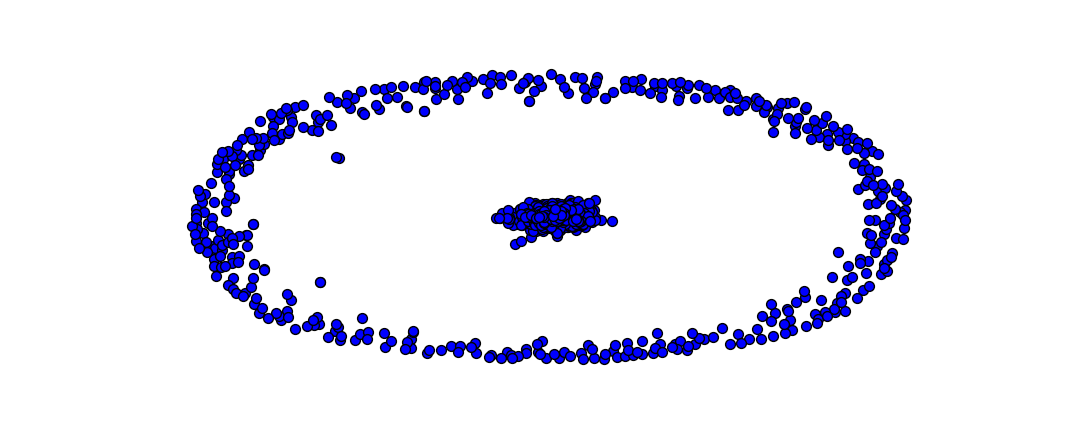

In [68]:
# Plot the graph
pos = nx.spring_layout(G)
plt.figure(num=1,figsize=(10, 4), dpi=50)
nx.draw(G,pos, node_color='blue', edge_color='r', node_size=50)
   
# show graph
fig = plt.gcf()
plt.show()
fig.savefig('graphs/main.png', bbox_inches='tight', dpi=300, transparent=True)

Apparently, there is a centralized number of nodes connected in the middle of the graph. Let's spot them

In [37]:
# print the length of each connected componenet subgraph
print [len(a) for a in nx.connected_component_subgraphs(G)]

[1, 4525, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Now let's save the centalized subgraph of length 4525 in a new graph

In [28]:
# Create a giant componenet graph
centralized = max(nx.connected_component_subgraphs(G), key=len)

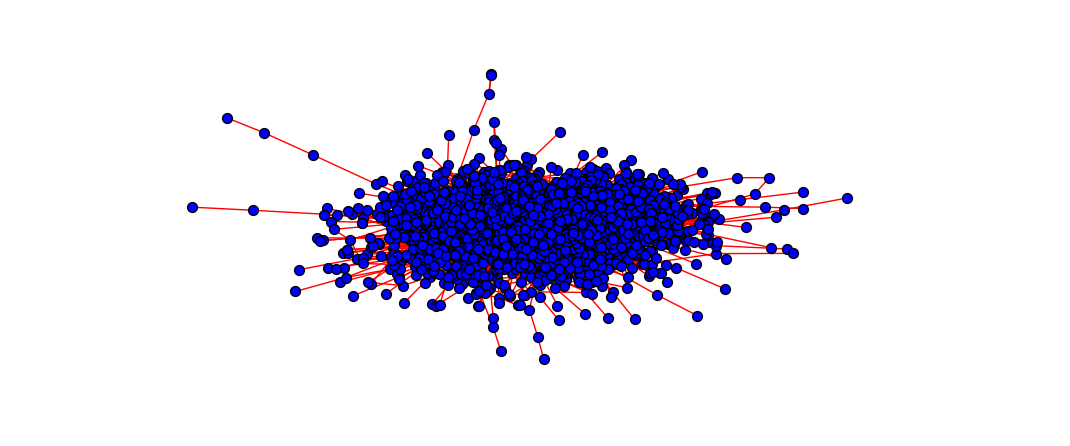

In [67]:
# Plot the centralized graph
pos_b = nx.spring_layout(centralized)
plt.figure(num=1,figsize=(10, 4), dpi=50)
nx.draw(centralized,pos_b, node_color='blue', edge_color='r', node_size=50) 

# show and save graph
fig = plt.gcf()
plt.show()
fig.savefig('graphs/centralized.png', bbox_inches='tight', dpi=300, transparent=True)

## Compute Centrality

### Betweeness centrality

In [44]:
# Compute betweeness centrality
bc = nx.betweenness_centrality(centralized)
sorted_bc = sorted(bc.items(), key=operator.itemgetter(1),reverse=True)

print sorted_bc[:5]

[('oai:arXiv.org:1508.04645', 0.01670069245804851), ('oai:arXiv.org:1601.04650', 0.011647742315973276), ('oai:arXiv.org:1601.07218', 0.010893881249720273), ('oai:arXiv.org:1507.02461', 0.010381441759204274), ('oai:arXiv.org:1512.04264', 0.00920934400220131)]


All of the papers in the list are those that were with high in and out degree. Those papers from the above list, occure in most of the shortest paths between other papers. Let's print the top paper!

In [68]:
print 'This is the most centered paper\n-------------------------------' 
df[df.identifier=='oai:arXiv.org:1508.04645']

This is the most centered paper
-------------------------------


,identifier,title,abstract,date
7557,oai:arXiv.org:1508.04645,"The multiplicative coalescent, inhomogeneous c...",One major open conjecture in the area of cri...,2016-05-03


In [71]:
# Print the full title of the paper
df.title.ix[7557]

'The multiplicative coalescent, inhomogeneous continuum random trees, and\n  new universality classes for critical random graphs'

### Eigenvector Centrality

In [45]:
# Compute eigenvector centrality
ec = nx.eigenvector_centrality(centralized)
sorted_ec = sorted(ec.items(), key=operator.itemgetter(1),reverse=True)

print sorted_ec[:5]

[('oai:arXiv.org:1511.04310', 0.18413713210602395), ('oai:arXiv.org:1601.06875', 0.16185908534757243), ('oai:arXiv.org:1602.01098', 0.15059613175320424), ('oai:arXiv.org:1601.04226', 0.1463528502700775), ('oai:arXiv.org:1512.08791', 0.14159701108266604)]


Eigenvector centrailty is a measure of the importance of a Node in a Network. Those papers from the above list are the ones who are the most famous and most of the rest of the papers are influenced by them so as to have a common words to them in their abstract.

In [69]:
print 'This is the most centered paper\n-------------------------------' 
df[df.identifier=='oai:arXiv.org:1511.04310']

This is the most centered paper
-------------------------------


,identifier,title,abstract,date
18261,oai:arXiv.org:1511.04310,Star formation efficiency along the radio jet ...,"Centaurus A is the most nearby powerful AGN,...",2016-01-27


In [72]:
# Print the full title of the paper
df.title.ix[18261]

'Star formation efficiency along the radio jet in Centaurus A'

## Community Detection

In [54]:
# Create the communities of the giant undirected graph created before
partition = community.best_partition(centralized)

############################# Modularity ######################################
print 'The Louvain modularity is: %2f\n\
-----------------------------------------------------------------------------------------' \
% community.modularity(partition, centralized)

############################# Communities #####################################
counts = Counter(e for e in partition.values())
ordered_counts = collections.OrderedDict(sorted(counts.items()))
com_size = len(counts)
print '\nThere are %d new communities(number 0 to %d) with a number of papers in each one of them: '\
% (com_size,(com_size-1))
for i,j in ordered_counts.items():
    print i,j
print '-----------------------------------------------------------------------------------------'

############################# Check Community #################################
print '\nThe papers in the community no.7 are: '
for k,v in partition.items():
    if v == 7:
        pprint.pprint(k)

The Louvain modularity is: 0.576669
-----------------------------------------------------------------------------------------

There are 14 new communities(number 0 to 13) with a number of papers in each one of them: 
0 869
1 227
2 548
3 1337
4 583
5 515
6 210
7 5
8 4
9 201
10 22
11 4
12 4
13 2
-----------------------------------------------------------------------------------------

The papers in the community no.7 are: 
'oai:arXiv.org:1510.04610'
'oai:arXiv.org:1508.01757'
'oai:arXiv.org:1601.06442'
'oai:arXiv.org:1512.03668'
'oai:arXiv.org:1511.07260'


The high mudularity shown (0.58) means that the communities created are well-structured and non-overlapping. Now let's print those papers and check their topics. They must be close to each other.

In [88]:
# Let's print those papers
df[df.identifier.isin(k for k,v in partition.items() if v == 7)]

,identifier,title,abstract,date,topic
6582,oai:arXiv.org:1508.01757,Shell evolution approaching the N=20 island of...,The levels in 26Na with single particle char...,2016-06-06,physics:nucl-ex
14199,oai:arXiv.org:1510.04610,Theoretical studies of possible toroidal high-...,We review our theoretical knowledge of possi...,2016-06-22,physics:nucl-th
19814,oai:arXiv.org:1511.07260,IPOPv2 online service for the generation of op...,In the framework of the present phase -- IPO...,2016-02-17,physics:astro-ph
22882,oai:arXiv.org:1512.03668,The New SI and the CODATA recommended values o...,This note aims at pointing out some standing...,2016-09-22,physics:physics
32682,oai:arXiv.org:1601.06442,Exotic neutron-rich medium-mass nuclei with re...,We present the first application of the newl...,2016-11-01,physics:nucl-th


Indeed all five papers are  in the physics topic!

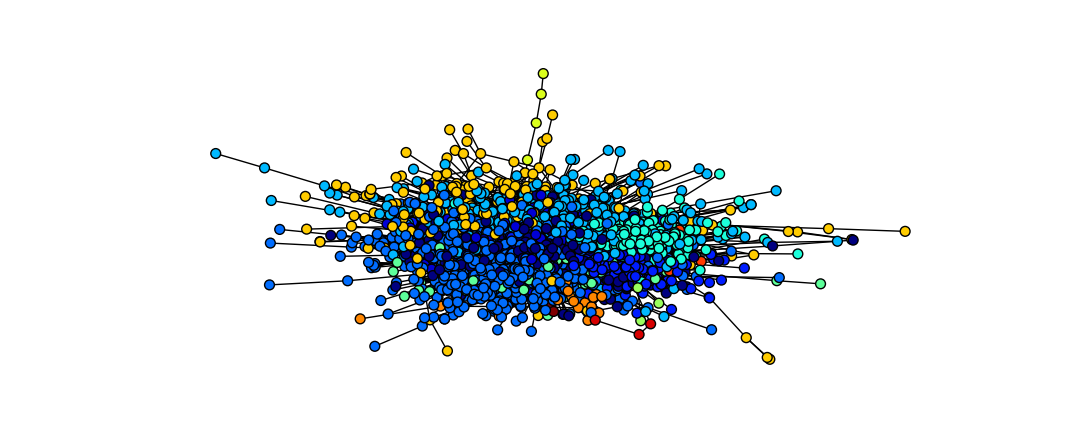

In [66]:
# Plot the community graph
values = [partition.get(node) for node in centralized.nodes()]
plt.figure(num=1,figsize=(10, 4), dpi=50)
nx.draw_spring(centralized, cmap = plt.get_cmap('jet'), node_color = values, node_size=50, with_labels=False)
   
# show graph
fig = plt.gcf()
plt.show()
fig.savefig('graphs/community.png', bbox_inches='tight', dpi=300, transparent=True)

## WordCloud

We will try to create a wordcloud of community number 3 which is the one with the higher number of papers.

In [84]:
# Save community 3 abstracts in a seperate variable
community_3 = df[df.identifier.isin(k for k,v in partition.items() if v == 3)]['abstract']

# Create a huge concatenated string
string = community_3.str.cat(sep=' ')

# Tokenize it
tokens = tokenizer(string)

# Remove stopwords
clean_tokens = remove_stopwords(tokens)

# Lemmatize tokens
lemmatized_tokens = token_lemmatizer(clean_tokens)

In [110]:
# Hue-Saturation-Lightness (HSL) functions, given as “hsl(hue, saturation%, lightness%)” where
#   hue is the colour given as an angle between 0 and 360 (red=0, green=120, blue=240), saturation
#   is a value between 0% and 100% (gray=0%, full color=100%), and lightness is a value between
#   0% and 100% (black=0%, normal=50%, white=100%). For example, “hsl(0,100%,50%)” is pure red.
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(50, 70)

In [ ]:
# Create a function that turns the lemmatized_tokens back to a string
def generate_string(bag):
    s = ''
    s+=' '.join([word for word in bag])
    return s

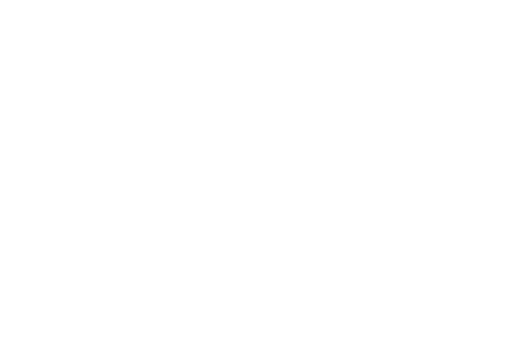

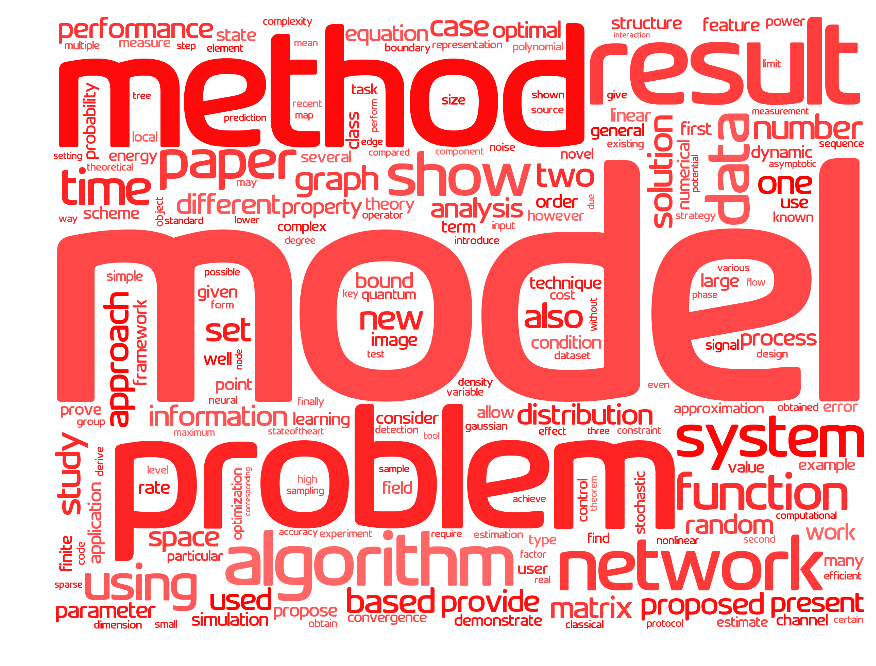

In [111]:
# Generate string from bag_of_words
s = generate_string(lemmatized_tokens)

# Exclude some more from the cloud
#stopwords = {'deleted', 'gt'}
#STOPWORDS = STOPWORDS.union(stopwords)

# Create a mask as a stencil for the word cloud
mask_shirt = imread('screens/computer.png',flatten=True)

# Set requirements for the bag_of_words and generate it
wc = WordCloud(font_path='fonts/CloudWorld.ttf', 
               background_color="white",  
               width=1800, 
               height=1400, 
               mask=mask_shirt,
               stopwords=STOPWORDS,
               mode='RGBA',
               margin=10,
               min_font_size=6,
               random_state=1).generate(s)

# Recolor the world cloud object using the HSL function
wc = wc.recolor(color_func=red_color_func, random_state=3)

# Show and save
plt.axis("off")
plt.figure(figsize=(12,8),dpi=500)
img=plt.imshow(wc)
fig = plt.gcf()
plt.show()
fig.savefig('screens/cloud_12.png', bbox_inches='tight', dpi=300, transparent=True)